# MICROBIOLOGICAL RESEARCH 

### PROBLEM UNDERSTANDING:

Premise 1:
- I'm working with microbiological researchers who are investigating cancer in parasitic micro-organisms
- Researchers have an electron microscope that can capture very high resolution images of micro-organisms (MOs for simplicity). (100000 x 100000 pixels)
- Each image is an image of a single MO. It is blob of arbitrary shape. MO blob covers >25% of the whole image
- Image can be viewed as : if pixel black -> it is within or MO boundary, else -> it is the area outside the MO
- There are no white spaces inside the MO blob

Premise 2:
- Researchers have injected the MO with a dye that lights up wherever the dye is present 
- This sensor also captures an image of the same MO at the same instant. This image has the same resolution.
- Dye might leak outside the MO
- A parasite is said to have cancer if the total amount of dye within its body exceeds 10% of the area occupied by the parasite


### MY APPROACH AND THOUGHT PROCESS:

- Right of the bat, I would need a way to represent these two images
- Given the statement, in any image more than 25% of the pixels are occupied by the MO. A sparse matrix in this case would not be optimal as it is better to use only when 1 values are sparsely distributed in the matrix.
- Therefore, I decided the best way to store these images would be to create dense NumPy matrix.
- Now that I have my two arrays, I will then feed them into a 'has_cancer()' function, which returns if the micro-organism has cancer or not.
- The likelihood of cancer will calculated by checking whether: count(common elements in the two arrays)/ length(image_array) > 0.1
- Based on the outcome of the function, I will store either both the actual and dye image, or only the actual image in my data structure
- Finally I will provide a function that converts that accesses any image from the datastructure and returns the original tiff image

### PROCESS FLOW:

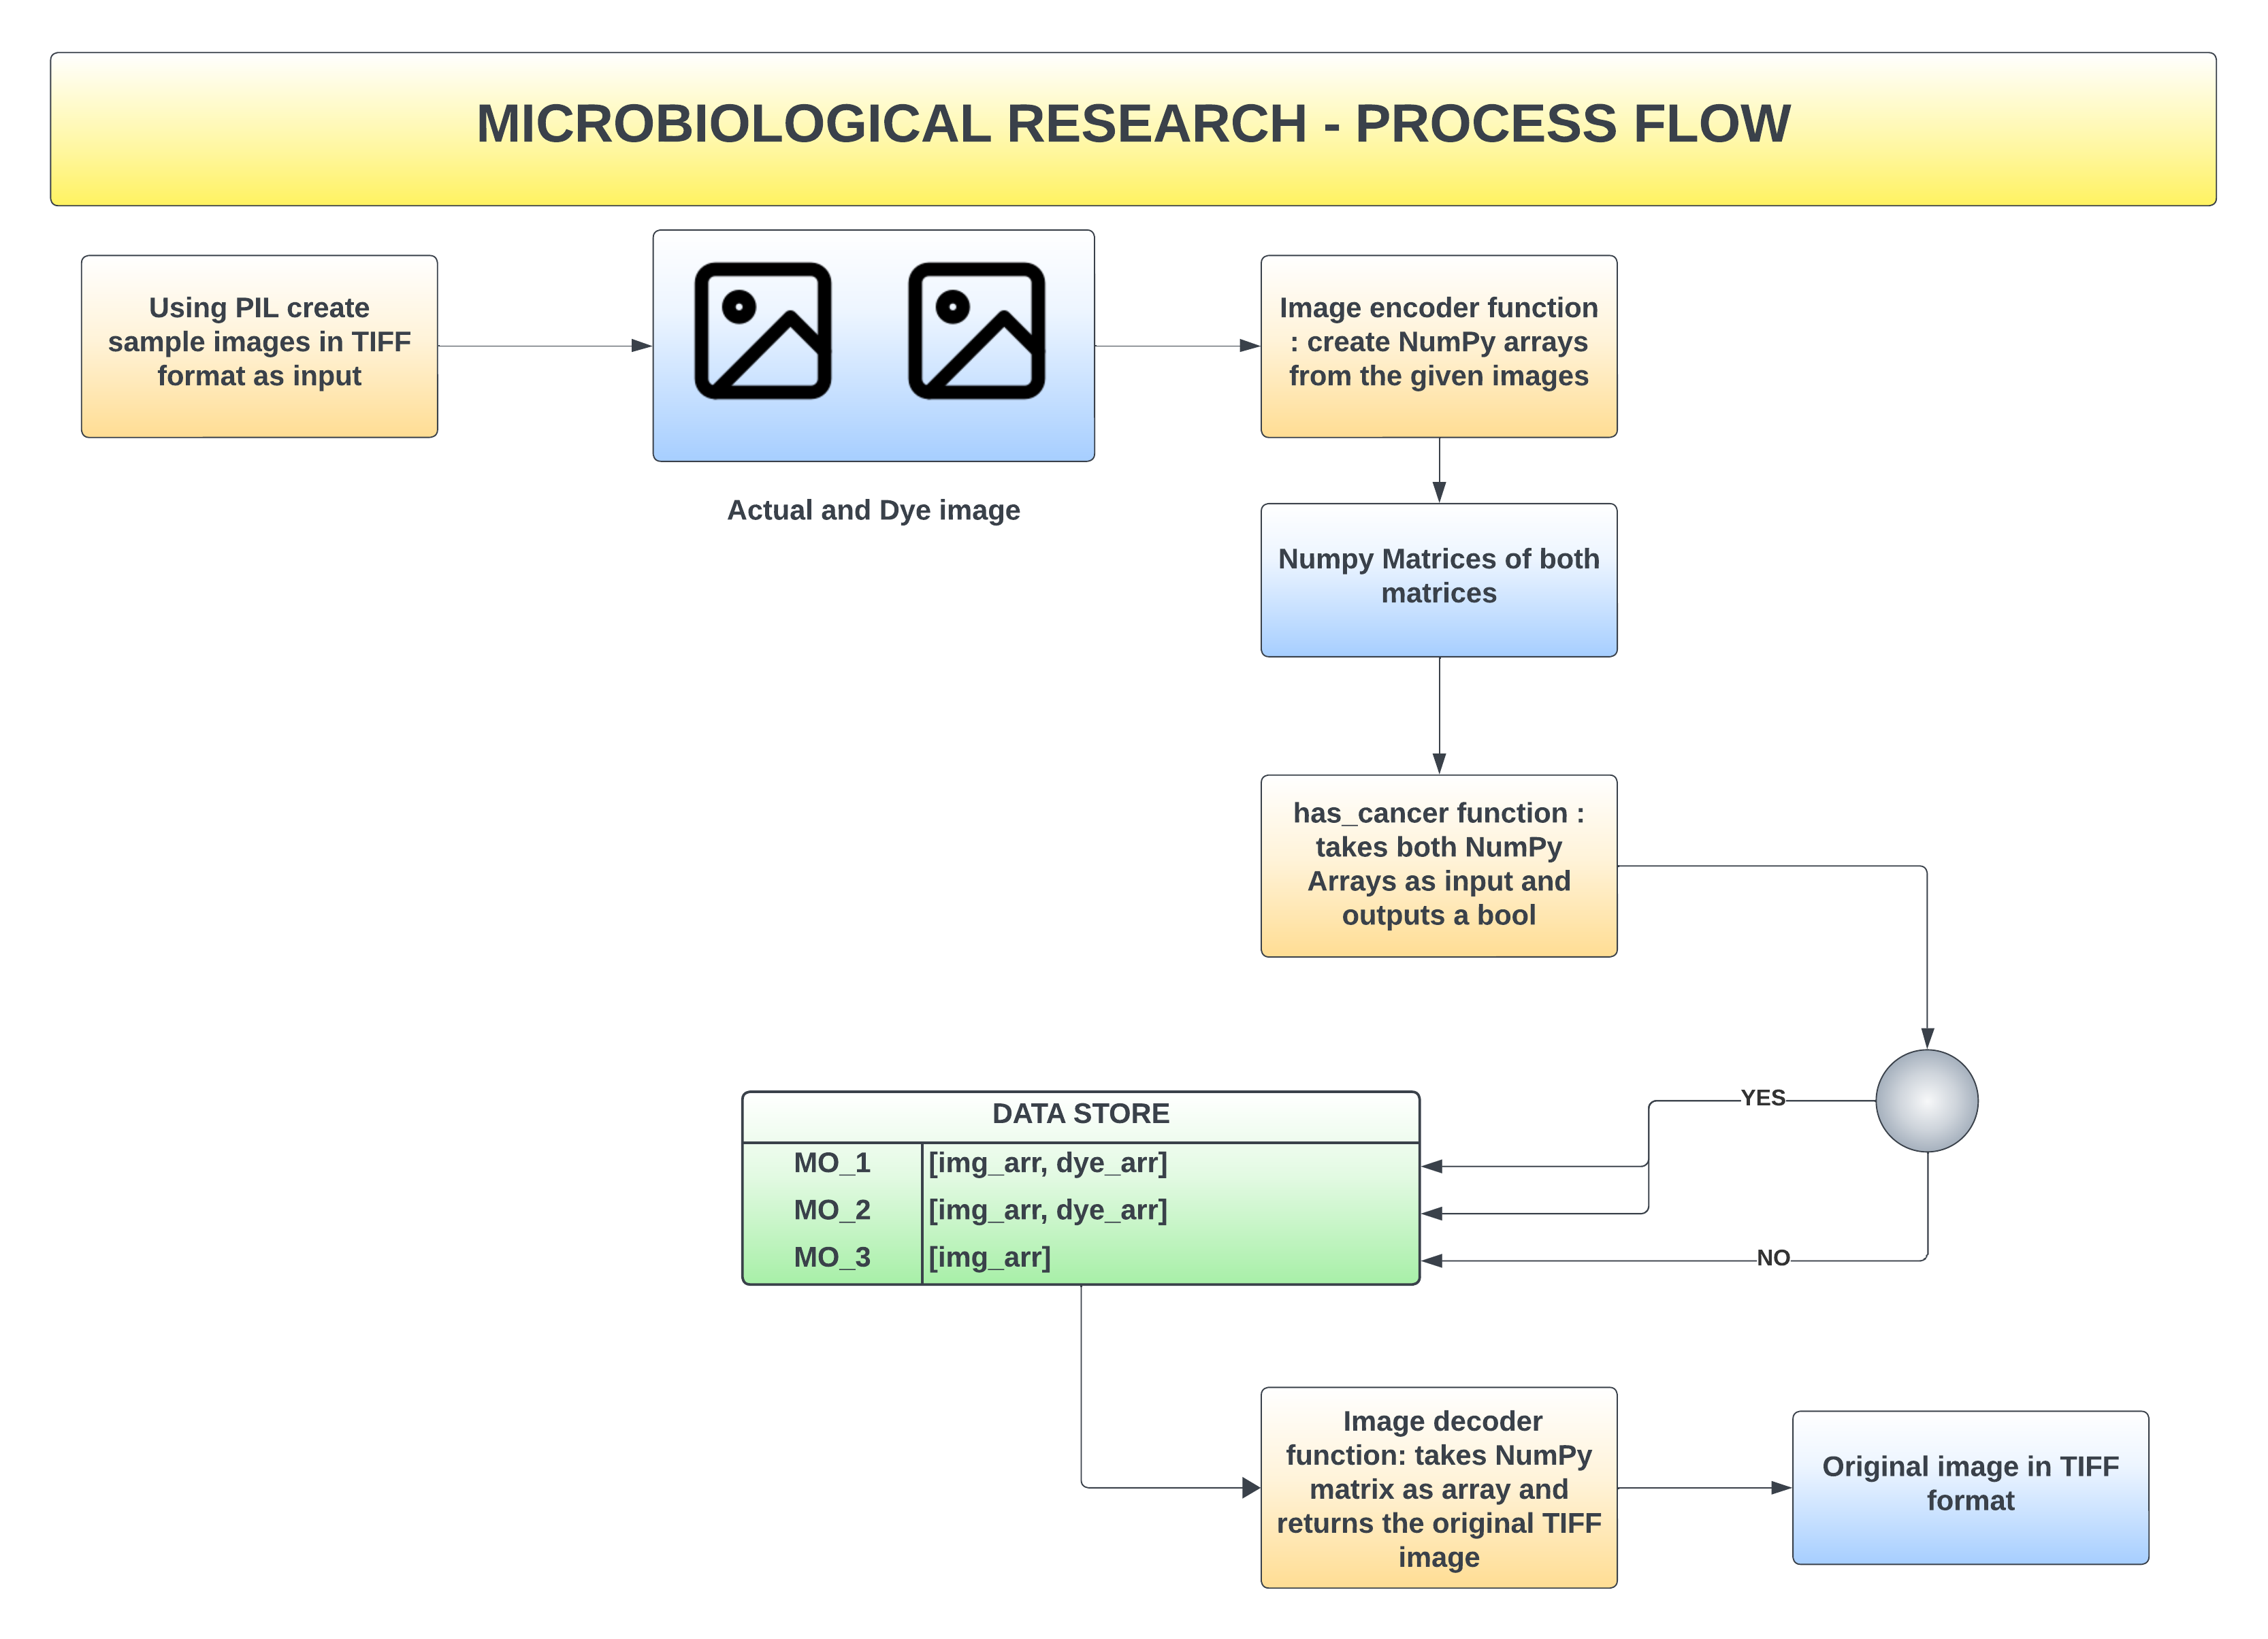

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit.png')

Note - If the image does not load, please open 'Dragonfruit.png' for the process flow diagram 

#### STEP 1 : In what format are input images by the microscope and dye sensor stored?
 - Upon researching and weighing up my options, I decided to use the TIFF format as the input image format
 - This is because it provides a lossless compression and is good in dealing with binary images
 - This format is easier to work with in Python and I can use it for further processing
 - Therefore I assume that from the microscope and dye sensor I will get two images : mo_img.TIFF and dye_img.TIFF

#### STEP 2 : Creating sample images for my experiments
 - I will now create sample images to conduct my experiments
 - First I create a sample mo1.TIFF : This contains a blob constituting 25% of the image occupying the top-left quadrant in the image. This will be by MO image.
 - Next I create a sample dye1.TIFF : This takes my MO image and adds a single adjacent pixel (to simulate leakage). This will be my cancer positive test
 - Finally, I create a sample dye2.TIFF : This will just be a blank image. This will be my cancer negative test
 - I used the below code to create these images. I apply a compression technique for faster computation and reduce the storage space for each image from about 1 GB to 70 MB
 - Finally, I make a copy of mo1.TIFF and store it as mo2.TIFF. This is to demonstrate my data structure implemented to store these images.
 - My created files are attached in the folder . I comment out the image creation code after creation to avoid computing them again while testing

- Importing necessary packages

In [2]:
! pip install Pillow -q
! pip install numpy -q
! pip install tqdm -q

In [3]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import time  
import os
Image.MAX_IMAGE_PIXELS = None

In [4]:
#######################################
####### IMAGE GENERATION CODE #########
#######################################

# # Define the image dimensions
# width = 100000
# height = 100000
# # Create an empty NumPy array of zeros with the specified dimensions
# image = np.zeros((height, width), dtype=np.uint8)
# # Set the top-left quadrant to 1
# image[:height // 2, :width // 2] = 1
# # Enable compression and save the image with compression
# compression = "tiff_lzw"  # You can choose the compression method you prefer
# with tqdm(total=3, desc="Processing images") as pbar:
#     image_pil = Image.fromarray(image)
#     image_pil.save("mo1.tiff", compression=compression)
#     pbar.update(1)
#     # Set the center pixel to 1 in the image (dye_img_pos.tiff)
#     image[height // 2, width // 2] = 1
#     image_pil = Image.fromarray(image)
#     image_pil.save("dye1.tiff", compression=compression)
#     pbar.update(1)
#     # Reset image to all zeros
#     image = np.zeros((height, width), dtype=np.uint8)
#     # Save an empty image (dye_img_neg.tiff)
#     image_pil = Image.fromarray(image)
#     image_pil.save("dye2.tiff", compression=compression)
#     pbar.update(1)


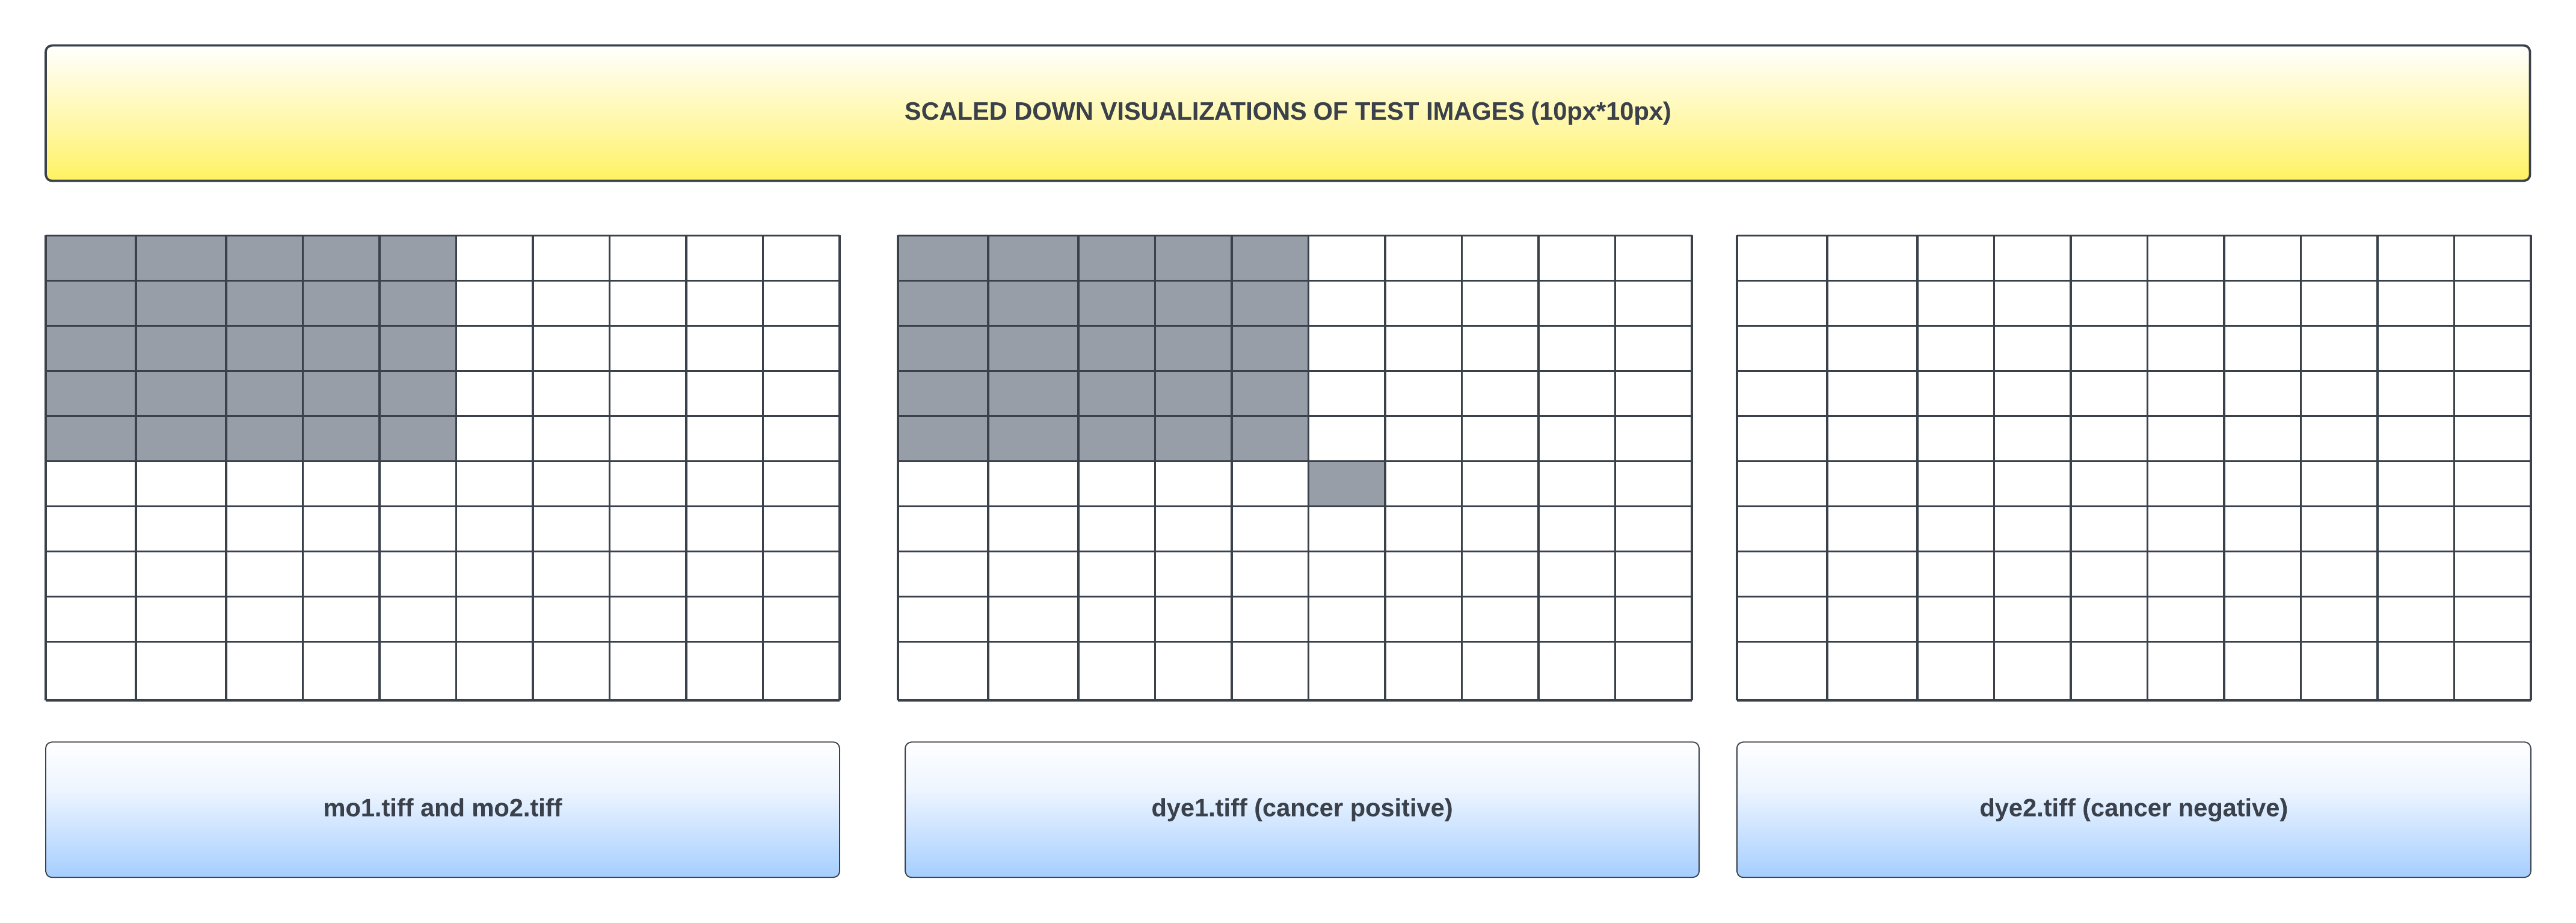

In [5]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_test_images.png')

#### STEP 3 : Image encoding
 - For further processing I will create dense NumPy matrices out of our image files.
 - This will be the first processing step in my system as I am assuming that my input image files will be in .tiff format
 - Below I define a function that takes an image as input and outputs the corresponding dense matrix
 

In [6]:
from PIL import Image
def encode_img(img):
    img = Image.open(img)
    image_array = np.array(img)
    return image_array

In [7]:
mo1_array = encode_img('mo1.tiff')

In [8]:
mo2_array = mo1_array # since both images are identical

In [9]:
dye1_array = encode_img('dye1.tiff')

In [10]:
dye2_array = np.zeros((100000, 100000), dtype=np.uint8) # since this image only has 0 values, using np.zeros() is computationally much faster

#### STEP 4 : Defining our has_cancer function
 - The function takes two dense matrices , counts the common non-zero values and then divides it by the count of non_zero values of the image array

In [11]:
def has_cancer(array1, array2):
    start_time = time.time()
    # Ensure both arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Count the number of positions where both arrays have a value of 1
    common_ones = np.count_nonzero((array1 == 1) & (array2 == 1))

    # Count the number of 1 values in the first array
    total_ones_in_array1 = np.count_nonzero(array1 == 1)

    # Calculate the ratio
    ratio = common_ones / total_ones_in_array1

    # Check if the ratio is greater than 0.1
    if ratio > 0.1:
        result =  True
    else:
        result =  False
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the execution time
    print(f"Execution time: {elapsed_time} seconds")

    return result

#### STEP 5 : Refining our has_cancer function
 - We tweak the function to multiply same position element in both arrays. We then compute only the nonzero values from the product. This completely removes an expensive operation

In [12]:
def has_cancer_optimized(array1, array2):
    start_time = time.time()
    # Ensure both arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Calculate the element-wise product of the two arrays
    elementwise_product = array1 & array2

    # Count the number of positions where both arrays have a value of 1
    common_ones = np.count_nonzero(elementwise_product)

    # Count the number of 1 values in the first array
    total_ones_in_array1 = np.count_nonzero(array1)

    # Calculate the ratio
    ratio = common_ones / total_ones_in_array1

    # Check if the ratio is greater than 0.1
    if ratio > 0.1:
        result = True
    else:
        result = False
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print the execution time
    print(f"Execution time: {elapsed_time} seconds")

    return result


#### STEP 6 : Testing our has_cancer function with our sample data


In [13]:
print(has_cancer(mo1_array,dye1_array))

Execution time: 15.853293895721436 seconds
True


In [14]:
print(has_cancer_optimized(mo1_array,dye1_array))

Execution time: 7.969639778137207 seconds
True


In [15]:
print(has_cancer_optimized(mo2_array,dye2_array))

Execution time: 7.769025564193726 seconds
False


#### STEP 7 : Storing our data
- I specify a dictionary to store the images.
- The keys will be the name of the image (mo1,mo2.....)
- The values will be a list of numpy matrices. The 0th index will be the actual image matrix and 1st index will be dye image matrix. Dye matrix will only be stored if has_cancer_optimized returns True
- So for each pair of images captured by the microscope and dye sensor:

- 1. I define a function that takes the two images as input
- 2. Creates numpy dense matrices out of them
- 3. passes them through the has_cancer_optimized() function
- 4. If True, stores both images in our dictionary
- 5. If False, stores only the actual image in our dictionary

In [16]:
image_data = {}
import os
def process_images(microscope_image, dye_image):
    # Extract the base filename without the extension
    key = os.path.splitext(os.path.basename(microscope_image))[0]

    # Convert microscope_image and dye_image to NumPy arrays
    microscope_array = encode_img(microscope_image)
    dye_array = encode_img(dye_image)

    # Check if the images have cancer using has_cancer_optimized function
    if has_cancer_optimized(microscope_array, dye_array):
        # If True, store both images in the dictionary
        image_data[key] = [microscope_array, dye_array]
    else:
        # If False, store only the microscope image
        image_data[key] = [microscope_array, None]

### Resultant dictionary will look something like this :


Format :

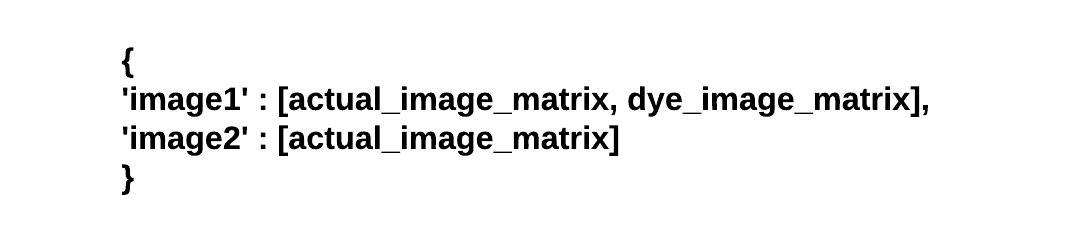

In [17]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_datastructure_format.png')

Note - If the image does not load, please open 'Dragonfruit_datastructure_format.png' for the datastructure format

#### Datastructure With values :
1. entry 1 is of a positive cancerous MO
2. entry 2 is of a negative cancerous MO

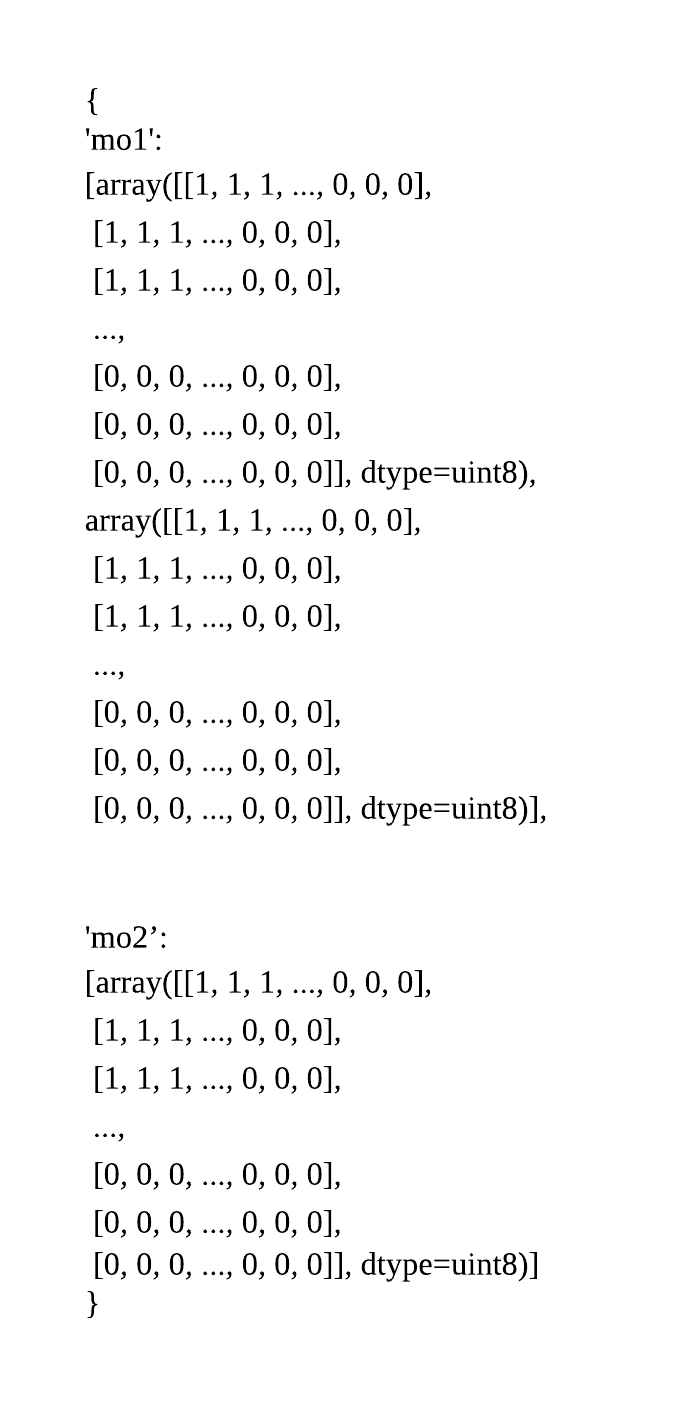

In [18]:
%matplotlib inline
from IPython.display import Image
Image('Dragonfruit_datastructure.png')

Note - If the image does not load, please open 'Dragonfruit_datastructure.png' for the datastructure with values

#### STEP 7 : Decoder function
- Finally, I specify a decoder function which takes a NumPy array and creates a .TIFF File
- This function is to be used on demand by the researchers
- If they want to retreive a particular image they simply need to search for the key - which is the original image name and then pass the NumPy matrix through the decoder function to get a reconstructed .TIFF image

In [19]:
from PIL import Image
def decode_img(array, filename, compression="tiff_lzw"):
    # Convert the NumPy array to a PIL Image
    image_pil = Image.fromarray(array)
    # Save the image with compression
    image_pil.save(filename, compression=compression)

In [20]:
# decode_img(dye2_array,'decoded_dye2.tiff')

## ANSWERS TO QUESTIONS ASKED IN THE CHALLENGE:

### QUESTION 1 : 
Come up with efficient data structures to represent both types of images: those generated
by the microscope, and those generated by the dye sensor. These need not have the same
representation; the only requirement is that they be compact and take as little storage
space as possible. Explain why you picked the representation you did for each image type,
and if possible estimate how much storage would be taken by the images. What is the
worst-case storage size in bytes for each image representation you chose?

Answer:
- I have chosen to represent both my images as NumPy dense matrices. This is because these are binary images and numpy arrays are an efficient way to store large data with binary values.
- While numpy arrays store all values, sparse matrices store only the 1 values (sort of like a list of co-ordinates). However, I did not choose sparse matrices, though they are more storage efficient. The thought process behind this was, since it is stated that an MO will take up a minimum of 25% of the space of the image. for a 100,000 by 100,000 image. That is around 2500000000 pixels. This cannot be a sparse matrix
- I used NumPy arrays because they are one of the best ways to represent multi-dimensional data and easy to do arithmetical and other processing techniques on in downstream workflows
- I assumed both image to be .tiff files. I was able to create a 100000 x 100000 pixel compressed tiff file of max_size 70.7 MB
- To estimate the storage of my chosen Data Structure - > NumPy Arrays, I will use the formula :
#### Storage (in bytes) = (image width) * (image height) * bit-depth / 8 * Number of Channels

- Plugging in values :
- image_width = 100000px
- image_height = 100000px
- bit-depth = 1 (each pixel can take only one of two values)
- Number of channels = 1 (for binary images)
- Storage in bytes comes out to be 1.25 * 10^10
- So in the worst case, storage in bytes for my datastructure would be : 1.25 * 10^10 which is roughly 11.68 GB



### QUESTION 2 : 
Before the researchers give you real images to work with, you would like to test out any
code you write. To this end, you would like to create “fake” simulated images and pretend
they were captured by the microscope and the dye sensor. Using the data structures you
chose in (1) above, write code to create such simulated images. Try and be as realistic in the
generated images as possible.

Answer :

In STEP 7 of my implementation I define a decoder function, which takes a NumPy array as input and returns an image in .tiff file as the output.

- I use the Pillow python library for this task
- For my fake or simulated images, I create 4 such images:
- 1. mo1 : image with top left quadrant completely black and everything else white
- 2. mo2 : copy of mo1 for negative test
- 3. dye1 : image with top left quadrant completely black and a single additional blob - adjacent pixel also black (to simulate leakage)
- 4. dye2 : image with no black values for negative test

In STEP 2, 3 and 7, I have described how to encode and decode data to and from NumPY matrices and tiff files.


### QUESTION 3 : 
Using the simulated images generated by the code you wrote for (2) above as input, write a
function to compute whether a parasite has cancer or not.

Answer :

In STEP 4, I define my has_cancer() function :
- Here, I compute the non-zero values of each image array
- I check if the  value : count(common non_zero values)/count(non_zero values in actual image) is over the threshold of 0.1
- If it is , then the MO has cancer

### QUESTION 4 : 
You give your code from (3) to the researchers, who run it and find that it is running too
slowly for their liking. What can you do to improve the execution speed? Write the code to
implement the fastest possible version you can think of for the function in (3).

In STEP 5, I refine my has_cancer() implementation:
- Here, instead of computing common 1 values for each matrix, I multiply the two matrices element-wise.
- Then I simply count the number of non_zero values for the element-wise multiplication divided by number of 1's in image matrix
- This saves me computation time and significantly reduces my runtime

### ENHANCEMENTS and CONSIDERATIONS:

- We can scale our images down (Down-sampling) to a more consumable format. For example a 100000 * 100000 pixel image can be downsampled to a 10 * 10 pixel image, keeping the same information.
- For this we can just divide the original image into tiles and create a resultant image where each pixel represents a tile. However, the challenge would be that if the image is not uniform, then we'd have to use thresholding to assign 1 or 0 to the tile, which becomes an accuracy consideration

- Also we can think of superimposition of the dye and the microscope image right after they are captured. This will result in a single matrix with  dye pixels, mo+dye pixels, mo pixels and blank pixels. Now we can calculate if count(mo+dye)/count(mo) > 0.1 . Therefore we need to work with only one matrix. And finally we extract the original image from the combined image and store it in our datastructure according to the rule

### Tools I used for this challenge
- Google - to research about large images
- ChatGPT - for code assistance and debugging
- Lucid chart  - for visualizations
- Python - Specially tifffile and PIL packages, for helping me work with images

# Final Thoughts and Comments

I'd like to thank the Dragonfruit.AI team for presenting an interesting problem to solve. It was engaging and gave me a new appreciation for the computation of large image data. I look forward to hearing your feedback on my effort at tackling this problem statement!

Yours Sincerely,
Shikhar